# 手作りルールを用いた再ランク候補モデル

このモデルは、特徴量を設計し、アイテムやユーザにマージし、最終的に20を選ぶために再ランクモデル（XGBなど）を学習することで改善することができる。

このノートブックを調整・改良するために、新しいロジックやモデルを実験するためのローカルCVスキームを構築する必要がある。

このコンペティションでは、「セッション」は実際には一意の「ユーザー」を意味する。

我々の課題は、1,671,803人のテスト「ユーザー」（つまり「セッション」）のそれぞれが将来何をするかを予測することです。

各テスト「ユーザー」（つまり「セッション」）に対して、残りの1週間のテスト期間中に何をクリックし、カートに入れ、注文するかを予測する必要がある。

# ステップ1 - 候補の生成
各テストユーザに対して、可能性のある選択肢、すなわち候補を生成する。

このノートでは、5つのソースから候補を生成している。

* クリック数、カート数、注文数のユーザー履歴
* テスト週間のクリック数、カート数、注文数で最も多かった20件
* クリック/カート/注文のCo-visitation matrix（タイプ重み付け付き
* カート/注文からカート/注文へのCo-visitation matrix（buy2buyと呼ぶ
* クリック/カート/注文とクリックのCo-visitation matrix（時間重み付けあり

# ステップ2 - 再ランク付けと20の選択
候補のリストが与えられたら、20個を予測対象として選択しなければならない。

このノートでは、手作業で作成したルールセットを使ってこれを行う。

XGBoostモデルを学習させることで、予測値を向上させることができる。

私たちの手作りルールは、以下を優先します。

* 過去に訪問した最も新しい項目
* 過去に複数回訪問した商品
* 以前にカートまたは注文に入れた商品
* カート/オーダーとカート/オーダーのCo-visitation matrix
* 現在の人気商品

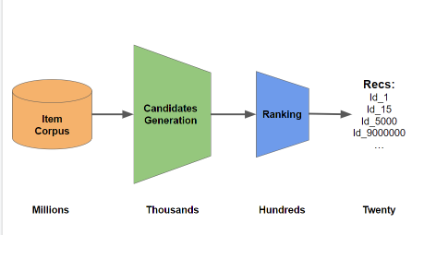

# ステップ1 - RAPIDSによる候補の生成
候補生成のために、3つのCo-visitation Matrixを構築する。

1.ユーザーの以前のclicks/carts/ordersを考慮し、carts/ordersの人気度を計算する。

この行列にtype-weighted(スコアリングの重み)を適用する。

2.ユーザーの以前のcarts/orders to carts/ordersの人気を計算するものである。

この行列を「buy2buy」行列と呼ぶ。

3.ユーザーの前回のclicks/carts/ordersがあれば、clicksの人気度を計算する。

この行列にtime-weightedをする。

これらの行列を高速に計算するために、RAPIDS cuDF GPUを使用する

In [1]:
!nvidia-smi

Mon Jan 16 09:54:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    45W / 350W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q cudf-cu11 dask-cudf-cu11 --extra-index-url=https://pypi.ngc.nvidia.com

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.8/442.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 108.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.6/453.6 KB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 106.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 923.4/923.4 KB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requir

In [3]:
VER = 5
import pandas as pd
import numpy as np
import os,sys,pickle,glob,gc
from collections import Counter
import cudf,itertools
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
print('We will use RAPIDS version',cudf.__version__)

We will use RAPIDS version 22.12.0


# RAPIDSで3つのCo-visitation Matrixを計算する

GPU上のRAPIDS cuDFを用いて、3つのco-visitation行列を計算します。

これは、他の公開ノートブックのようにPandasのCPUを使うよりも30倍速いです! 

最大速度のために、変数DISK_PIECESを、使用しているGPUに基づいて、メモリエラーが発生しない最小の数値に設定してください。

32GB GPUラムでこのコードをオフラインで実行する場合、DISK_PIECES = 1を使用して、各共視行列をほぼ1分で計算することができます! 

KaggleのGPUは16GBのラムしか持っていないので、DISK_PIECES = 4を使用し、それぞれ3分という驚くべき時間がかかっています!

以下、計算を高速化するためのトリックをいくつか紹介します。

* PandasのCPUの代わりにRAPIDSのcuDF GPUを使用する
* ディスクを一度読み込んでCPUのRAMに保存し、後でGPUで複数回使用できるようにする
* GPUで可能な限りの大容量データを一度に処理する
* データを2段階に分けてマージ 複数の小から単一の中へ 複数の中から単一の大へ
* 結果をディクショナリーではなく、パーケットとして書き込む

In [4]:
%%time
# cache functions
def read_file(f):
    return cudf.DataFrame(data_cache[f])
def read_file_to_cache(f):
    df = pd.read_parquet(f)
    df.ts = (df.ts/1000).astype('int32')
    df['type'] = df['type'].map(type_labels).astype('int8')
    return df

# cache the data on cpu before processing on gpu
data_cache = {}
type_labels = {'clicks':0,'carts':1,'orders':2}
# files = test + train
files = glob.glob('/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/dataset/original/*_parquet/*')
for f in files:
    data_cache[f] = read_file_to_cache(f)

# chunk parameters
READ_CT = 5
CHUNK = int(np.ceil(len(files)/6))
print(f'We will process {len(files)} files, in gropus of {READ_CT} and chunks of {CHUNK}.')
# 146個のファイルを、5個単位と25個単位のチャンクで処理する予定です。

We will process 146 files, in gropus of 5 and chunks of 25.
CPU times: user 32.9 s, sys: 8.03 s, total: 41 s
Wall time: 53.1 s


# 1)'Carts Orders' Co-visitation Matrix - Type Weighted

In [5]:
%%time
type_weight = {0:1,1:6,2:3}

# use smallest disk_pieces possible without memory error
DISK_PIECES = 4
SIZE = 1.86e6/DISK_PIECES

# compute in parts for memory management
# メモリ管理用に分割して計算する
for PART in range(DISK_PIECES):
    print()
    print('### DISK PART',PART+1)

    for j in range(6):
        a = j*CHUNK
        b = min((j+1)*CHUNK,len(files)) #CHUNK=25,len(files)=146
        print(f'Processing files {a} thru {b-1} in groups of {READ_CT} ...')
        
        for k in range(a,b,READ_CT): # READ_CT=5
            df = [read_file(files[k])]
            # 5つごとに読み込んでdfを作成
            for i in range(1,READ_CT):
                if k+i<b:
                    df.append(read_file(files[k+i]))
            
            df = cudf.concat(df,ignore_index=True,axis=0)
            df = df.sort_values(['session','ts'],ascending=[True,False])

            df = df.reset_index(drop=True)

            # sessionの最後の方を使用(30回以上アクションがあるものは削除)
            df['n'] = df.groupby('session').cumcount()
            df = df.loc[df.n<30].drop('n',axis=1)
            
            # ペア作成
            df = df.merge(df,on='session')
            
            #アクションの間隔が1日以内かつ同じ商品でない行を残す
            df = df.loc[((df.ts_x - df.ts_y).abs()<24*60*60)&(df.aid_x != df.aid_y)]

            #memory management compute in parts
            df = df.loc[(df.aid_x >= PART*SIZE)&(df.aid_x < (PART+1)*SIZE)]

            # session・aid_x・aid_yが同じ行を削除
            df = df[['session','aid_x','aid_y','type_y']].drop_duplicates(['session','aid_x','aid_y'])
            # wgt行を追加
            df['wgt'] = df.type_y.map(type_weight)
            # 列をカット
            df = df[['aid_x','aid_y','wgt']]
            # wgt列をfloat32型に変更
            df.wgt = df.wgt.astype('float32')
            # aid_x・aid_yで組み分けして同じグループのwgtを合計
            df = df.groupby(['aid_x','aid_y']).wgt.sum()

            #combine inner chunks
            if k == a:
                tmp2 = df
            else:
                tmp2 = tmp2.add(df,fill_value=0)
            print(k,', ',end='')
        print()
        
        # combine outer chunks
        if a == 0:
            tmp = tmp2
        else:
            tmp = tmp.add(tmp2,fill_value=0)
        del tmp2,df
        gc.collect()

    # convert matrix to dictionary
    # インデックスをリセット
    tmp = tmp.reset_index()
    # aid_xを昇順、wgtを降順にソート
    tmp = tmp.sort_values(['aid_x','wgt'],ascending=[True,False])

    # save top 15
    # インデックスをリセット
    tmp = tmp.reset_index(drop=True)
    # n列にaid_xごとに分類したaid_yの累積和を追加
    tmp['n'] = tmp.groupby('aid_x').aid_y.cumcount()

    # もう片方のペアの人気度TOP15まで残す
    tmp = tmp.loc[tmp.n<15].drop('n',axis=1)

    # save part to disk
    tmp.to_pandas().to_parquet(f'top_15_carts_orders_v{VER}_{PART}.pqt')    


### DISK PART 1
Processing files 0 thru 24 in groups of 5 ...
0 , 5 , 10 , 15 , 20 , 
Processing files 25 thru 49 in groups of 5 ...
25 , 30 , 35 , 40 , 45 , 
Processing files 50 thru 74 in groups of 5 ...
50 , 55 , 60 , 65 , 70 , 
Processing files 75 thru 99 in groups of 5 ...
75 , 80 , 85 , 90 , 95 , 
Processing files 100 thru 124 in groups of 5 ...
100 , 105 , 110 , 115 , 120 , 
Processing files 125 thru 145 in groups of 5 ...
125 , 130 , 135 , 140 , 145 , 

### DISK PART 2
Processing files 0 thru 24 in groups of 5 ...
0 , 5 , 10 , 15 , 20 , 
Processing files 25 thru 49 in groups of 5 ...
25 , 30 , 35 , 40 , 45 , 
Processing files 50 thru 74 in groups of 5 ...
50 , 55 , 60 , 65 , 70 , 
Processing files 75 thru 99 in groups of 5 ...
75 , 80 , 85 , 90 , 95 , 
Processing files 100 thru 124 in groups of 5 ...
100 , 105 , 110 , 115 , 120 , 
Processing files 125 thru 145 in groups of 5 ...
125 , 130 , 135 , 140 , 145 , 

### DISK PART 3
Processing files 0 thru 24 in groups of 5 ...
0 , 5

# 2) "Buy2Buy" Co-visitation Matrix

In [6]:
%%time
# USE SMALLEST DISK_PIECES POSSIBLE WITHOUT MEMORY ERROR
DISK_PIECES = 1
SIZE = 1.86e6/DISK_PIECES

# COMPUTE IN PARTS FOR MEMORY MANGEMENT
for PART in range(DISK_PIECES):
    print()
    print('### DISK PART',PART+1)
    
    # MERGE IS FASTEST PROCESSING CHUNKS WITHIN CHUNKS
    # => OUTER CHUNKS
    for j in range(6):
        a = j*CHUNK
        b = min( (j+1)*CHUNK, len(files) )
        print(f'Processing files {a} thru {b-1} in groups of {READ_CT}...')
        
        # => INNER CHUNKS
        for k in range(a,b,READ_CT):
            # READ FILE
            df = [read_file(files[k])]
            for i in range(1,READ_CT): 
                if k+i<b: df.append( read_file(files[k+i]) )
            df = cudf.concat(df,ignore_index=True,axis=0)
            # carts/ordersのみを使用
            df = df.loc[df['type'].isin([1,2])]
            df = df.sort_values(['session','ts'],ascending=[True,False])
            # sessionの最後の方を使用(30回以上アクションがあるものは削除)
            df = df.reset_index(drop=True)
            df['n'] = df.groupby('session').cumcount()
            df = df.loc[df.n<30].drop('n',axis=1)
            # ペア作成
            df = df.merge(df,on='session')
            # アクションの間隔が14日以内かつ違う商品idの行を残す
            df = df.loc[ ((df.ts_x - df.ts_y).abs()< 14 * 24 * 60 * 60) & (df.aid_x != df.aid_y) ]
            # MEMORY MANAGEMENT COMPUTE IN PARTS
            df = df.loc[(df.aid_x >= PART*SIZE)&(df.aid_x < (PART+1)*SIZE)]
            # session・aid_x・aid_yが同じ行を削除
            df = df[['session', 'aid_x', 'aid_y','type_y']].drop_duplicates(['session', 'aid_x', 'aid_y'])
            # wgt列を1代入
            df['wgt'] = 1
            # aid_x,aid_x,wgt列を取り出す
            df = df[['aid_x','aid_y','wgt']]
            # wgt列をfloat32型に変更
            df.wgt = df.wgt.astype('float32')
            # aid_x・aid_yで組み分けして同じグループのwgtを合計
            df = df.groupby(['aid_x','aid_y']).wgt.sum()
            # COMBINE INNER CHUNKS
            if k==a: tmp2 = df
            else: tmp2 = tmp2.add(df, fill_value=0)
            print(k,', ',end='')
        print()
        # COMBINE OUTER CHUNKS
        if a==0: tmp = tmp2
        else: tmp = tmp.add(tmp2, fill_value=0)
        del tmp2, df
        gc.collect()
    # CONVERT MATRIX TO DICTIONARY
    # インデックスをリセット
    tmp = tmp.reset_index()
    # aid_xを昇順・wgtを降順に変更
    tmp = tmp.sort_values(['aid_x','wgt'],ascending=[True,False])
    # SAVE TOP 15
    # インデックスをリセット
    tmp = tmp.reset_index(drop=True)
    # n列にaid_xごとに分類したaid_yの累積和を追加
    tmp['n'] = tmp.groupby('aid_x').aid_y.cumcount()
    # もう片方のペアの人気度TOP15まで残す
    tmp = tmp.loc[tmp.n<15].drop('n',axis=1)
    # SAVE PART TO DISK (convert to pandas first uses less memory)
    tmp.to_pandas().to_parquet(f'top_15_buy2buy_v{VER}_{PART}.pqt')


### DISK PART 1
Processing files 0 thru 24 in groups of 5...
0 , 5 , 10 , 15 , 20 , 
Processing files 25 thru 49 in groups of 5...
25 , 30 , 35 , 40 , 45 , 
Processing files 50 thru 74 in groups of 5...
50 , 55 , 60 , 65 , 70 , 
Processing files 75 thru 99 in groups of 5...
75 , 80 , 85 , 90 , 95 , 
Processing files 100 thru 124 in groups of 5...
100 , 105 , 110 , 115 , 120 , 
Processing files 125 thru 145 in groups of 5...
125 , 130 , 135 , 140 , 145 , 
CPU times: user 9.69 s, sys: 2.42 s, total: 12.1 s
Wall time: 11.9 s


# 3) "Clicks" Co-visitation Matrix - Time weighted

In [7]:
%%time
# use smallest disk_pieces possible withoout memory error
DISK_PIECES = 4
SIZE = 1.86e6/DISK_PIECES

# compute in parts for memory management
for PART in range(DISK_PIECES):
    print()
    print('### DISK PART',PART+1)

    #merge is fastest processing chunks within chunks
    # => outer chunks
    for j in range(6):
        a = j*CHUNK
        b = min((j+1)*CHUNK,len(files))
        print(f'Processing files {a} thru {b-1} in group of {READ_CT}...')

        # => inner chunks
        for k in range(a,b,READ_CT):
            # read file
            df = [read_file(files[k])]
            for i in range(1,READ_CT):
                if k+i<b:
                    df.append(read_file(files[k+i]))
            df = cudf.concat(df,ignore_index=True,axis=0)
            df = df.sort_values(['session','ts'],ascending=[True,False])

            # sessionの最後の方を使用(30回以上アクションがあるものは削除)
            df = df.reset_index(drop=True)
            df['n'] = df.groupby('session').cumcount()
            df = df.loc[df.n<30].drop('n',axis=1)

            # ペア作成
            df = df.merge(df,on='session')
            #アクションの間隔が1日以内かつ同じ商品でない行を残す
            df = df.loc[((df.ts_x-df.ts_y).abs()<24*60*60)&(df.aid_x!=df.aid_y)]

            # memory management conpute in parts
            df = df.loc[(df.aid_x>=PART*SIZE)&(df.aid_x<(PART+1)+SIZE)]

            # session・aid_x・aid_yが同じ行を削除
            df = df[['session','aid_x','aid_y','ts_x']].drop_duplicates(['session','aid_x','aid_y'])
            # wgt行にtime-weightedを追加
            df['wgt'] = 1 + 3*(df.ts_x-1659304800)/(1662328791-1659304800)
            # aid_x,aid_y,wgt列を残す
            df = df[['aid_x','aid_y','wgt']]
            # wgt列をfloat32型に変更
            df.wgt = df.wgt.astype('float32')
            # aid_x・aid_yで組み分けして同じグループのwgtを合計
            df = df.groupby(['aid_x','aid_y']).wgt.sum()

            # combine inner chunke
            if k==a:
                tmp2 = df
            else:
                tmp2 = tmp2.add(df,fill_value=0)
            print(k,', ',end='')
        print()

        # combine outer chunks
        if a==0:
            tmp = tmp2
        else:
            tmp = tmp.add(tmp2,fill_value=0)
        del tmp2,df
        gc.collect()

    # convert matrix to dictionary
    # インデックスをリセット
    tmp = tmp.reset_index()
    # aid_xを昇順,wgtを降順に変更
    tmp = tmp.sort_values(['aid_x','wgt'],ascending=[True,False])

    # save top 20
    # インデックスをリセット
    tmp = tmp.reset_index(drop=True)
    # n列にaid_xごとに分類したaid_yの累積和を追加
    tmp['n'] = tmp.groupby('aid_x').aid_y.cumcount()
    # もう片方のペアの人気度TOP20まで残す
    tmp = tmp.loc[tmp.n<20].drop('n',axis=1)

    # save part to disk
    tmp.to_pandas().to_parquet(f'top_20_clicks_v{VER}_{PART}.pqt')


### DISK PART 1
Processing files 0 thru 24 in group of 5...
0 , 5 , 10 , 15 , 20 , 
Processing files 25 thru 49 in group of 5...
25 , 30 , 35 , 40 , 45 , 
Processing files 50 thru 74 in group of 5...
50 , 55 , 60 , 65 , 70 , 
Processing files 75 thru 99 in group of 5...
75 , 80 , 85 , 90 , 95 , 
Processing files 100 thru 124 in group of 5...
100 , 105 , 110 , 115 , 120 , 
Processing files 125 thru 145 in group of 5...
125 , 130 , 135 , 140 , 145 , 

### DISK PART 2
Processing files 0 thru 24 in group of 5...
0 , 5 , 10 , 15 , 20 , 
Processing files 25 thru 49 in group of 5...
25 , 30 , 35 , 40 , 45 , 
Processing files 50 thru 74 in group of 5...
50 , 55 , 60 , 65 , 70 , 
Processing files 75 thru 99 in group of 5...
75 , 80 , 85 , 90 , 95 , 
Processing files 100 thru 124 in group of 5...
100 , 105 , 110 , 115 , 120 , 
Processing files 125 thru 145 in group of 5...
125 , 130 , 135 , 140 , 145 , 

### DISK PART 3
Processing files 0 thru 24 in group of 5...
0 , 5 , 10 , 15 , 20 , 
Process

In [8]:
# free memory
del data_cache,tmp
_ = gc.collect()

# Step2 - ReRank(choose 20) using handcrafted rules


In [9]:
def load_test():
    dfs = []
    for e,chunk_file in enumerate(glob.glob('/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/dataset/original/test_parquet/*')):
        chunk = pd.read_parquet(chunk_file)
        chunk.ts = (chunk.ts/1000).astype('int32')
        chunk['type'] = chunk['type'].map(type_labels).astype('int8')
        dfs.append(chunk)
    return pd.concat(dfs).reset_index(drop=True)

test_df = load_test()
print('Test data has shape',test_df.shape)
test_df.head()

Test data has shape (6928123, 4)


,session,aid,ts,type
0,12899779,59625,1661724000,0
1,12899780,1142000,1661724000,0
2,12899780,582732,1661724058,0
3,12899780,973453,1661724109,0
4,12899780,736515,1661724136,0


In [10]:
%%time
# parquetからdictに変換
def pqt_to_dict(df):
    return df.groupby('aid_x').aid_y.apply(list).to_dict()

# load three Co-visitation matrix
top_20_clicks = pqt_to_dict(pd.read_parquet(f'top_20_clicks_v{VER}_0.pqt'))

for k in range(1,DISK_PIECES):
    top_20_clicks.update(pqt_to_dict(pd.read_parquet(f'top_20_clicks_v{VER}_{k}.pqt')))

top_20_buys = pqt_to_dict(pd.read_parquet(f'top_15_carts_orders_v{VER}_0.pqt'))

for k in range(1,DISK_PIECES):
    top_20_buys.update(pqt_to_dict(pd.read_parquet(f'top_15_carts_orders_v{VER}_{k}.pqt')))

top_20_buy2buy = pqt_to_dict(pd.read_parquet(f'top_15_buy2buy_v{VER}_0.pqt'))

# top clicks and order in test
top_clicks = test_df.loc[test_df['type']=='clicks','aid'].value_counts().index.values[:20]
top_orders = test_df.loc[test_df['type']=='orders','aid'].value_counts().index.values[:20]

print('Here are size of out 3 co-visitation matrix')
print(len(top_20_clicks),len(top_20_buy2buy),len(top_20_buys))

Here are size of out 3 co-visitation matrix
460363 1168768 1837166
CPU times: user 1min, sys: 2.9 s, total: 1min 3s
Wall time: 1min


In [11]:
#type_weight_multipliers = {'clicks': 1, 'carts': 6, 'orders': 3}
type_weight_multipliers = {0: 1, 1: 6, 2: 3}

# 入力されるdfはtest_dfをsessionごとに組み分けされたものである
# clicksを予測する関数
def suggest_clicks(df):
    # USER HISTORY AIDS AND TYPES
    
    # aid列をリスト化
    aids=df.aid.tolist()
    
    # type列をリスト化
    types = df.type.tolist()
    
    # ユニークな商品idを取得
    unique_aids = list(dict.fromkeys(aids[::-1] ))
    
    # RERANK CANDIDATES USING WEIGHTS
    # ユニークな商品idが20以上の場合
    if len(unique_aids)>=20:
        # 重み作成
        weights=np.logspace(0.1,1,len(aids),base=2, endpoint=True)-1
        # カウンター作成
        aids_temp = Counter() 
        # RERANK BASED ON REPEAT ITEMS AND TYPE OF ITEMS
        # 重みづけ
        for aid,w,t in zip(aids,weights,types): 
            aids_temp[aid] += w * type_weight_multipliers[t]
        #上位20商品だけ取り出し
        sorted_aids = [k for k,v in aids_temp.most_common(20)]
        return sorted_aids
    # USE "CLICKS" CO-VISITATION MATRIX
    # ユニークな商品idがtop_20_clicksのキーの中に存在したら、そのペアをaid2とする
    aids2 = list(itertools.chain(*[top_20_clicks[aid] for aid in unique_aids if aid in top_20_clicks]))
    # RERANK CANDIDATES
    # aids2の上位20がユニークidに入ってなかったら取得
    top_aids2 = [aid2 for aid2, cnt in Counter(aids2).most_common(20) if aid2 not in unique_aids]
    # ユニークな商品idと不足分をtop_aids2で補う
    result = unique_aids + top_aids2[:20 - len(unique_aids)]
    # USE TOP20 TEST CLICKS
    # 不足分をtest_dfのtop_clicksで補う
    return result + list(top_clicks)[:20-len(result)]

# ordersとcartsを予測する関数
def suggest_buys(df):
    # USER HISTORY AIDS AND TYPES
    
    # 商品idをリスト化
    aids=df.aid.tolist()
    
    # typeをリスト化
    types = df.type.tolist()
    
    # UNIQUE AIDS AND UNIQUE BUYS
    # ユニークな商品idを取得
    unique_aids = list(dict.fromkeys(aids[::-1] ))
    
    # ordersとcartsを取得
    df = df.loc[(df['type']==1)|(df['type']==2)]
    
    # ユニークなordersとcartsの商品idを取得
    unique_buys = list(dict.fromkeys( df.aid.tolist()[::-1] ))
    
    # RERANK CANDIDATES USING WEIGHTS
    # ユニークな商品idが20以上の時
    if len(unique_aids)>=20:
        # 重み作成
        weights=np.logspace(0.5,1,len(aids),base=2, endpoint=True)-1
        # カウンター作成
        aids_temp = Counter() 
        # RERANK BASED ON REPEAT ITEMS AND TYPE OF ITEMS
        # 重みづけ
        for aid,w,t in zip(aids,weights,types): 
            aids_temp[aid] += w * type_weight_multipliers[t]
        # RERANK CANDIDATES USING "BUY2BUY" CO-VISITATION MATRIX
        # ユニークな商品id(carts/orders)がtop_20_buy2buyのキーの中に存在したら、そのペアをaid3とする
        aids3 = list(itertools.chain(*[top_20_buy2buy[aid] for aid in unique_buys if aid in top_20_buy2buy]))
        # aid3を重み増し
        for aid in aids3:
            aids_temp[aid] += 0.1
        # 上位20を取得
        sorted_aids = [k for k,v in aids_temp.most_common(20)]
        return sorted_aids
    # USE "CART ORDER" CO-VISITATION MATRIX
    # ユニークな商品idがtop_20_buysのキーの中に存在したら、そのペアをaid2とする
    aids2 = list(itertools.chain(*[top_20_buys[aid] for aid in unique_aids if aid in top_20_buys]))
    # USE "BUY2BUY" CO-VISITATION MATRIX
    # ユニークな商品idがtop_20_buy2buyのキーの中に存在したら、そのペアをaid3とする
    aids3 = list(itertools.chain(*[top_20_buy2buy[aid] for aid in unique_buys if aid in top_20_buy2buy]))
    # RERANK CANDIDATES
    # aids2とaids3の上位20がユニークidに入ってなかったら取得
    top_aids2 = [aid2 for aid2, cnt in Counter(aids2+aids3).most_common(20) if aid2 not in unique_aids] 
    # ユニークな商品idと不足分をtop_aids2で補う
    result = unique_aids + top_aids2[:20 - len(unique_aids)]
    # USE TOP20 TEST ORDERS
    # 不足分をtest_dfのtop_clicksで補う
    return result + list(top_orders)[:20-len(result)]


In [20]:
len(top_20_buys)

1837166

In [21]:
len(top_20_buy2buy)

1168768

# create submission

In [12]:
%%time
pred_df_clicks = test_df.sort_values(["session", "ts"]).groupby(["session"]).apply(
    lambda x: suggest_clicks(x)
)

pred_df_buys = test_df.sort_values(["session", "ts"]).groupby(["session"]).apply(
    lambda x: suggest_buys(x)
)

CPU times: user 22min 38s, sys: 36.9 s, total: 23min 15s
Wall time: 22min 30s


In [13]:
clicks_pred_df = pd.DataFrame(pred_df_clicks.add_suffix("_clicks"), columns=["labels"]).reset_index()
orders_pred_df = pd.DataFrame(pred_df_buys.add_suffix("_orders"), columns=["labels"]).reset_index()
carts_pred_df = pd.DataFrame(pred_df_buys.add_suffix("_carts"), columns=["labels"]).reset_index()

In [14]:
pred_df = pd.concat([clicks_pred_df, orders_pred_df, carts_pred_df])
pred_df.columns = ["session_type", "labels"]
pred_df["labels"] = pred_df.labels.apply(lambda x: " ".join(map(str,x)))
pred_df.to_csv("Candidate ReRank Model - [LB 0.575].csv", index=False)
pred_df.to_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/submission/Candidate ReRank Model - [LB 0.575].csv', index=False)
pred_df.head()

,session_type,labels
0,12899779_clicks,59625 1253524 737445 438191 731692 1790770 942...
1,12899780_clicks,1142000 736515 973453 582732
2,12899781_clicks,918667 199008 194067 57315 141736 1460571 7594...
3,12899782_clicks,834354 595994 740494 889671 987399 779477 1344...
4,12899783_clicks,1817895 607638 1754419 1216820 1729553 300127 ...


In [15]:
!pip install kaggle -q
import os
import json
f = open("/content/drive/MyDrive/Colab Notebooks/kaggle/kaggle.json", 'r')
json_data = json.load(f)
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

In [18]:
!kaggle competitions submit -c otto-recommender-system -f CandidateReRankModel.csv -m ""

100% 610M/610M [00:05<00:00, 114MB/s]
Successfully submitted to OTTO – Multi-Objective Recommender System